## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 == requests html
                - C <--> S
                - 1. html url 요청(최초화면)
                - 2. 새로운 페이지 요청 : html url 요청(2, 3페이지... 등)
                
                
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지 -> URL은 바뀌지 않는데 화면이 바뀐다 == requests json
                - 1. html 요청
                - 2. json url 요청 -> 딕셔너리 -> DF

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [2]:
import warnings
warnings.filterwarnings("ignore") #경고 문구 없애기
import pandas as pd
import requests

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집
- m.stock.naver.com -> 코스피
- 네트워크 탭에서 html 코드가 가장 먼저 받아진다.
- referer????
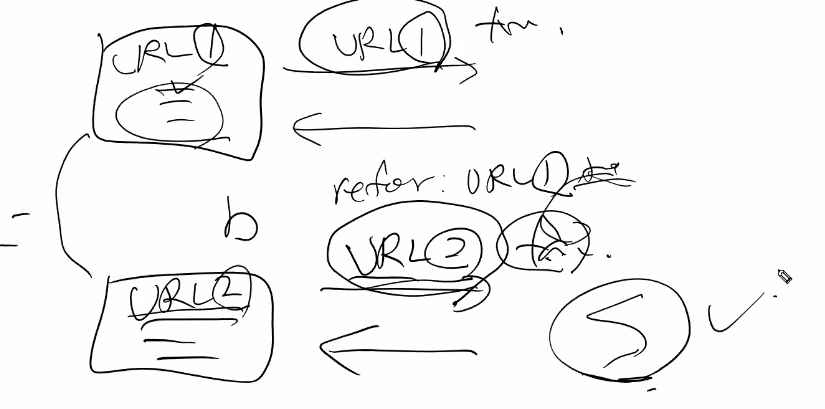
- user-agent?

In [3]:
page, page_size = 1, 10
url = f"https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}"
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=10&page=1'

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text
- Fetch/XHR 탭 headers - general

In [4]:
response = requests.get(url)
response

<Response [200]>

In [8]:
response.text[:300]

'[{"localTradedAt":"2023-02-16","closePrice":"2,473.46","compareToPreviousClosePrice":"45.56","compareToPreviousPrice":{"code":"2","text":"상승","name":"RISING"},"fluctuationsRatio":"1.88","openPrice":"2,444.06","highPrice":"2,474.62","lowPrice":"2,442.07"},{"localTradedAt":"2023-02-15","closePrice":"2'

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [110]:
data = response.json() #response type에서 json()함수를 이용해서 list type으로 변경
data

[{'localTradedAt': '2023-02-16',
  'closePrice': '2,473.46',
  'compareToPreviousClosePrice': '45.56',
  'compareToPreviousPrice': {'code': '2', 'text': '상승', 'name': 'RISING'},
  'fluctuationsRatio': '1.88',
  'openPrice': '2,444.06',
  'highPrice': '2,474.62',
  'lowPrice': '2,442.07'},
 {'localTradedAt': '2023-02-15',
  'closePrice': '2,427.90',
  'compareToPreviousClosePrice': '-37.74',
  'compareToPreviousPrice': {'code': '5', 'text': '하락', 'name': 'FALLING'},
  'fluctuationsRatio': '-1.53',
  'openPrice': '2,473.09',
  'highPrice': '2,473.44',
  'lowPrice': '2,424.16'},
 {'localTradedAt': '2023-02-14',
  'closePrice': '2,465.64',
  'compareToPreviousClosePrice': '12.94',
  'compareToPreviousPrice': {'code': '2', 'text': '상승', 'name': 'RISING'},
  'fluctuationsRatio': '0.53',
  'openPrice': '2,471.33',
  'highPrice': '2,480.34',
  'lowPrice': '2,459.83'},
 {'localTradedAt': '2023-02-13',
  'closePrice': '2,452.70',
  'compareToPreviousClosePrice': '-17.03',
  'compareToPreviousPri

In [17]:
df = pd.DataFrame(data)[["localTradedAt", "closePrice"]] #json포맷은 dataframe으로 만들기가 굉장히 쉽다
df

,localTradedAt,closePrice
0,2023-02-16,"2,473.46"
1,2023-02-15,"2,427.90"
2,2023-02-14,"2,465.64"
3,2023-02-13,"2,452.70"
4,2023-02-10,"2,469.73"
5,2023-02-09,"2,481.52"
6,2023-02-08,"2,483.64"
7,2023-02-07,"2,451.71"
8,2023-02-06,"2,438.19"
9,2023-02-03,"2,480.40"


#### 4. 함수로 만들기

In [23]:
def stock_price(code = "KOSPI", page = 1, page_size = 20): #default parameter
    """
    this function is crawling stock price from naver.
    params :
        code : str : KOSPI, KOSADAQ
        page : int
        page_size : int
    return :
        type : DaataFrame
    """
    #1. URL
    url = f"https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}"
    
    #2. request(URL) > response : json(str)
    response = requests.get(url)
    
    #3. json(str) > list, dict > DataFrame
    data = response.json()
    return pd.DataFrame(data)[["localTradedAt", "closePrice"]]

In [30]:
help(stock_price)

Help on function stock_price in module __main__:

stock_price(code='KOSPI', page=1, page_size=20)
    this function is crawling stock price from naver.
    params :
        code : str : KOSPI, KOSADAQ
        page : int
        page_size : int
    return :
        type : DaataFrame



In [32]:
dir(response)

['__attrs__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_content',
 '_content_consumed',
 '_next',
 'apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

In [29]:
df = stock_price(page_size = 60)
df.tail(2)

,localTradedAt,closePrice
58,2022-11-23,"2,418.01"
59,2022-11-22,"2,405.27"


#### 5. 원달러 환율 데이터 수집 : 실습

In [113]:
url = "https://m.stock.naver.com/front-api/v1/marketIndex/prices?page=1&category=exchange&reutersCode=FX_USDKRW"
response = requests.get(url)
data = response.json()
data

{'isSuccess': True,
 'detailCode': '',
 'message': '',
 'result': [{'localTradedAt': '2023-02-16',
   'closePrice': '1,291.50',
   'fluctuations': '2.50',
   'fluctuationsRatio': '0.19',
   'fluctuationsType': {'code': '2', 'text': '상승', 'name': 'RISING'},
   'cashBuyValue': '1,314.1',
   'cashSellValue': '1,268.9',
   'sendValue': '1,304.1',
   'receiveValue': '1,278.9'},
  {'localTradedAt': '2023-02-15',
   'closePrice': '1,289.00',
   'fluctuations': '19.00',
   'fluctuationsRatio': '1.50',
   'fluctuationsType': {'code': '2', 'text': '상승', 'name': 'RISING'},
   'cashBuyValue': '1,311.55',
   'cashSellValue': '1,266.45',
   'sendValue': '1,301.6',
   'receiveValue': '1,276.4'},
  {'localTradedAt': '2023-02-14',
   'closePrice': '1,270.00',
   'fluctuations': '-9.00',
   'fluctuationsRatio': '-0.70',
   'fluctuationsType': {'code': '5', 'text': '하락', 'name': 'FALLING'},
   'cashBuyValue': '1,292.22',
   'cashSellValue': '1,247.78',
   'sendValue': '1,282.4',
   'receiveValue': '1,257

In [53]:
def exchange_rate(code = "FX_USDKRW", page = 1):
    url = f"https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode={code}"
    response = requests.get(url)
    data = response.json()["result"]
    return pd.DataFrame(data)[["localTradedAt", "closePrice"]]

In [107]:
usd_1 = exchange_rate(page = 1)
usd_2 = exchange_rate(page = 2)

In [57]:
usd_df = pd.concat([usd_1, usd_2], ignore_index = True)
usd_df

,localTradedAt,closePrice
0,2023-02-16,"1,282.70"
1,2023-02-15,"1,289.00"
2,2023-02-14,"1,270.00"
3,2023-02-13,"1,279.00"
4,2023-02-10,"1,270.50"
5,2023-02-09,"1,259.00"
6,2023-02-08,"1,260.00"
7,2023-02-07,"1,262.00"
8,2023-02-06,"1,258.00"
9,2023-02-03,"1,251.00"


In [58]:
kospi_df = stock_price()
kospi_df.tail(2)

,localTradedAt,closePrice
18,2023-01-19,"2,380.34"
19,2023-01-18,"2,368.32"


In [61]:
kosdaq_df = stock_price(code = "KOSDAQ")
kosdaq_df.tail(2)

,localTradedAt,closePrice
18,2023-01-19,712.89
19,2023-01-18,711.75


#### 5-1. 전처리 후 시각화

In [119]:
#데이터 전처리 : 데이터 타입 변경
usd_1 = exchange_rate(page = 1)
usd_2 = exchange_rate(page = 2)
usd_df = pd.concat([usd_1, usd_2], ignore_index = True)
usd_df["usd"] = usd_df["closePrice"].apply(lambda data : float(data.replace(",", "")))
usd_df.tail(2)

,localTradedAt,closePrice,usd
18,2023-01-19,"1,237.00",1237.0
19,2023-01-18,"1,230.00",1230.0


In [120]:
kospi_df, kosdaq_df = stock_price(), stock_price(code = "KOSDAQ")
kospi_df["kospi"] = kospi_df["closePrice"].apply(lambda data : float(data.replace(",", "")))
kosdaq_df["kosdaq"] = kosdaq_df["closePrice"].apply(lambda data : float(data.replace(",", "")))

In [74]:
df = usd_df.copy()
df["kospi"] = kospi_df["kospi"]
df["kosdaq"] = kosdaq_df["kosdaq"]
df = df.drop(columns = ["closePrice"])
df.tail(2)

,localTradedAt,usd,kospi,kosdaq
18,2023-01-19,1237.0,2380.34,712.89
19,2023-01-18,1230.0,2368.32,711.75


In [82]:
#lambda : 파라미터와 리턴으로 이루어진 함수를 간단하게 작성하는 방법

#함수 3개 선언 ----> 저장공간 3칸 사용
def plus(n1, n2):
    return n1 + n2

def minus(n1, n2):
    return n1 - n2

def calc(func, n1, n2):
    return func(n1, n2)

In [83]:
calc(plus, 1, 2)

3

In [84]:
plus_lambda = lambda n1, n2: n1 + n2
plus_lambda(1, 2)

3

In [85]:
calc(lambda n1, n2 : n1 + n2, 1, 2)

3

In [90]:
#얕은복사, 깊은복사
data1 = [1, 2, 3]
data2 = data1 #얕은복사 : 주소 복사
data3 = data1.copy() #깊은복사 : 데이터 복사
print(data1, data2, data3)
data1[1] = 4
print(data1, data2, data3)

[1, 2, 3] [1, 2, 3] [1, 2, 3]
[1, 4, 3] [1, 4, 3] [1, 2, 3]


In [94]:
id(data1), id(data2), id(data3)

(2202222365184, 2202222365184, 2202341195200)

#### 6. 시각화

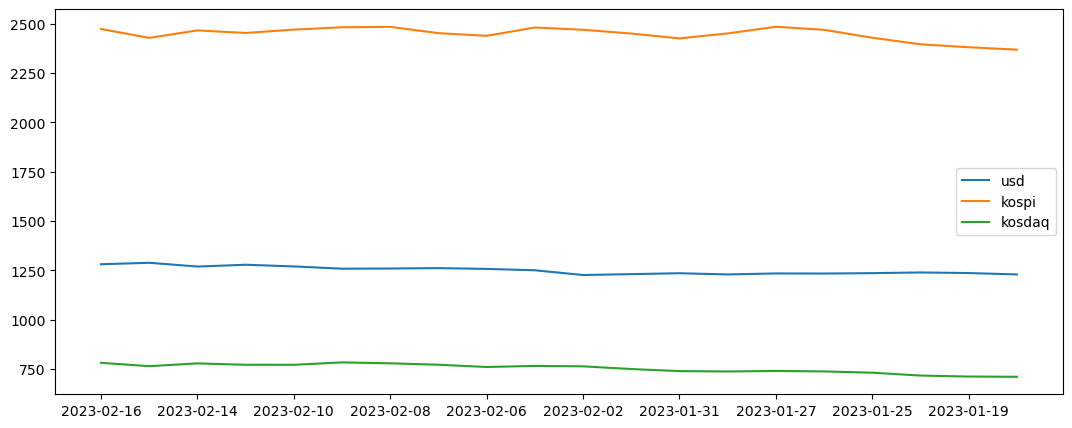

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
plt.plot(df["localTradedAt"], df["usd"], label = "usd")
plt.plot(df["localTradedAt"], df["kospi"], label = "kospi")
plt.plot(df["localTradedAt"], df["kosdaq"], label = "kosdaq")
plt.xticks(df["localTradedAt"][::2]) #x축 출력 간격 조정
plt.legend()
plt.show()

In [100]:
df["localTradedAt"][::2]

0     2023-02-16
2     2023-02-14
4     2023-02-10
6     2023-02-08
8     2023-02-06
10    2023-02-02
12    2023-01-31
14    2023-01-27
16    2023-01-25
18    2023-01-19
Name: localTradedAt, dtype: object

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [117]:
from sklearn.preprocessing import minmax_scale
minmax_scale(df["usd"])

array([0.88064516, 1.        , 0.69354839, 0.83870968, 0.7016129 ,
       0.51612903, 0.53225806, 0.56451613, 0.5       , 0.38709677,
       0.        , 0.07258065, 0.14516129, 0.0483871 , 0.12903226,
       0.12096774, 0.15322581, 0.20967742, 0.16129032, 0.0483871 ])

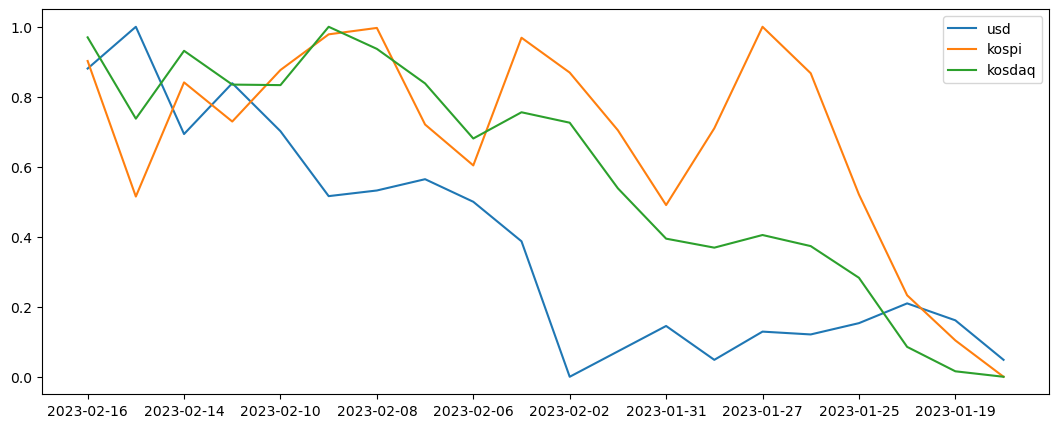

In [118]:
plt.figure(figsize = (13, 5))
plt.plot(df["localTradedAt"], minmax_scale(df["usd"]), label = "usd")
plt.plot(df["localTradedAt"], minmax_scale(df["kospi"]), label = "kospi")
plt.plot(df["localTradedAt"], minmax_scale(df["kosdaq"]), label = "kosdaq")
plt.xticks(df["localTradedAt"][::2]) #x축 출력 간격 조정
plt.legend()
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [106]:
df.corr()

,usd,kospi,kosdaq
usd,1.000000,0.295201,0.720437
kospi,0.295201,1.000000,0.780177
kosdaq,0.720437,0.780177,1.000000
